<a href="https://colab.research.google.com/github/danielkennedy1/CS6524_Computer_Vision/blob/main/CelebA_Conv_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import warnings
import kagglehub
from pathlib import Path
from google.colab import drive
from datetime import datetime


warnings.filterwarnings('ignore')

In [2]:
FOLDER_NUMBER = 5 # Change to put checkpoints into different folders
SAMPLE_COUNT = 50_000

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
warnings.filterwarnings('ignore')

Using device: cuda


In [5]:
dataset_path = kagglehub.dataset_download(
    "kushsheth/face-vae",
)

Using Colab cache for faster access to the 'face-vae' dataset.


In [6]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:SAMPLE_COUNT]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [7]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # [0, 1] -> [-1, 1]
])

In [8]:
dataset = CelebADataset(f'{dataset_path}/img_align_celeba/img_align_celeba', transform=transform)
dataloader = DataLoader(dataset, batch_size=758, shuffle=True, num_workers=0)

print(f"Dataset size: {len(dataset)}")
print(f"No. of Batches: {len(dataloader)}")
print(f"Sample shape: {dataset[0].shape}")

Dataset size: 50000
No. of Batches: 66
Sample shape: torch.Size([3, 256, 256])


In [9]:
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib
    this is used to visualize the data and also the outputs of our network
    '''
    image = (image + 1) / 2 # [-1, 1] -> [0, 1]
    plt.figure()
    plt.imshow(image.cpu().permute(1, 2, 0).numpy())
    plt.grid('off')
    plt.axis('off')
    plt.show()

VERY IMPORTANT: This should be Jim from The Office

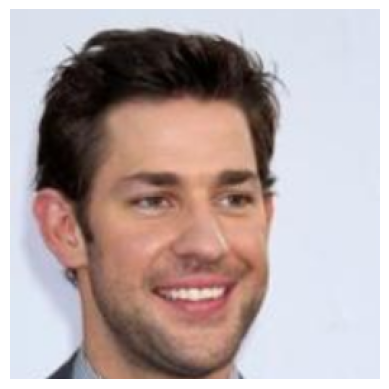

In [10]:
plot_image(dataset[0])

In [11]:
def conv_output_size(input_size, kernel_size, stride=1, padding=0):
    return (input_size + 2 * padding - kernel_size) // stride + 1

In [12]:
def convtranspose_output_size(input_size, kernel_size, stride=1, padding=0, output_padding=0):
    return (input_size - 1) * stride - 2 * padding + kernel_size + output_padding

In [13]:
conv_output_size(64, 4, 2, 1)

32

In [14]:
convtranspose_output_size(16, 4, 2, 1)

32

In [15]:
# --- Convolutional VAE ---
class ConvVAE(nn.Module):
    def __init__(self, latent_dimension: int, image_channels: int):
        super().__init__()
        self.latent_dim = latent_dimension
        self.image_channels = image_channels
        self.W_lat = 16
        self.H_lat = 16

        # Encoder: 3x256x256
        # -conv> 8x256x256
        # -conv> 16x256x256
        # -conv> 32x64x64
        # -conv> 64x64x64
        # -conv> 128x32x32
        # -conv> 256x32x32
        # -conv> 512x16x16
        # -conv> latent_dimx16x16 (latent_dim=512)
        # -flatten> 131072
        # -fcx2> latent_dim (mu, logvar)
        self.enc = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=3, stride=1, padding=1),  # 256x256
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  # 256x256
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=8, stride=4, padding=2),  # 64x64
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64x64
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 32x32
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(True),
            nn.Conv2d(512, self.latent_dim, kernel_size=3, stride=1, padding=1),  # 16x16
            nn.ReLU(True),
        )
        # Flatten (in decode)
        self.enc_fc_mu = nn.Linear(self.latent_dim * self.W_lat * self.H_lat, self.latent_dim)
        self.enc_fc_logvar = nn.Linear(self.latent_dim * self.W_lat * self.H_lat, self.latent_dim)

        # Decoder: latent_dim (z)
        # -fc> 131072
        # -reshape(in decode)> 512x16x16
        # -deconv> 512x16x16
        # -deconv> 256x16x16
        # -deconv> 128x32x32
        # -deconv> 32x64x64
        # -deconv> 16x64x64
        # -deconv> 8x256x256
        # -deconv> image_channelsx256x256
        self.dec_fc = nn.Linear(self.latent_dim, self.latent_dim * 16 * 16)
        # 16x16 (512)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, 512, kernel_size=3, stride=1, padding=1),  # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),  # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),  # 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  # 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=8, stride=4, padding=2),  # 256x256
            nn.ReLU(True),
            nn.ConvTranspose2d(8, image_channels, kernel_size=3, stride=1, padding=1),  # 256x256
            nn.Tanh(),  # output in [-1,1]
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu = self.enc_fc_mu(h)
        logvar = self.enc_fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z_vec):
        h = self.dec_fc(z_vec)
        h = h.view(z_vec.size(0), self.latent_dim, self.W_lat, self.H_lat)
        x_recon = self.dec(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z_vec = self.reparameterize(mu, logvar)
        x_recon = self.decode(z_vec)
        return x_recon, mu, logvar

def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl, recon_loss, kl

vae = ConvVAE(latent_dimension=512, image_channels=3).to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

print("VAE parameters (M):", sum(p.numel() for p in vae.parameters())/1e6)
print(vae)


VAE parameters (M): 210.578979
ConvVAE(
  (enc): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
  )
  (enc_fc_mu): Linear(in_features=131072, out_features=512, bias=True)
  (enc_fc_logvar): Linear(in_f

In [16]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl, recon_loss, kl

In [17]:
drive.mount('/content/drive')

checkpoint_dir = Path(f'/content/drive/MyDrive/CS6524/VAE_checkpoints_{FOLDER_NUMBER}')
checkpoint_dir.mkdir(exist_ok=True, parents=True)

Mounted at /content/drive


In [18]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

In [ ]:
num_vae_epochs = 100

sum_loss_history = []
recon_loss_history = []
kl_loss_history = []

vae.train()
for epoch in range(num_vae_epochs):
    pbar = tqdm(dataloader, desc=f"VAE Epoch {epoch+1}/{num_vae_epochs}")

    total_sum_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.00
    total_kl_loss = 0.0

    for imgs in pbar:
        imgs = imgs.to(device)
        x_recon, mu, logvar = vae(imgs)
        loss, r_loss, kl = vae_loss(x_recon, imgs, mu, logvar)

        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()

        total_sum_loss += loss.item() * imgs.size(0)
        total_recon_loss += r_loss.item() * imgs.size(0)
        total_kl_loss += kl.item() * imgs.size(0)
        pbar.set_postfix({"loss": loss.item(), "recon": r_loss.item(), "kl": kl.item()})

    save_checkpoint(vae, vae_opt, epoch, loss, checkpoint_dir / 'latest.pt')

    sum_loss_history.append(total_sum_loss / len(dataset))
    recon_loss_history.append(total_recon_loss / len(dataset))
    kl_loss_history.append(total_kl_loss / len(dataset))

    print(f"Epoch {epoch+1}: avg loss = {total_sum_loss/len(dataset):.4f}\n")


VAE Epoch 1/100: 100%|██████████| 66/66 [03:36<00:00,  3.28s/it, loss=5.37e+4, recon=5.35e+4, kl=270]


Epoch 1: avg loss = 68071.8928



VAE Epoch 2/100: 100%|██████████| 66/66 [03:34<00:00,  3.26s/it, loss=3.68e+4, recon=3.65e+4, kl=335]


Epoch 2: avg loss = 40856.3829



VAE Epoch 3/100: 100%|██████████| 66/66 [03:56<00:00,  3.59s/it, loss=3.06e+4, recon=3.02e+4, kl=402]


Epoch 3: avg loss = 33277.1404



VAE Epoch 4/100: 100%|██████████| 66/66 [03:58<00:00,  3.61s/it, loss=2.45e+4, recon=2.41e+4, kl=474]


Epoch 4: avg loss = 27672.2423



VAE Epoch 5/100: 100%|██████████| 66/66 [03:50<00:00,  3.50s/it, loss=1.64e+4, recon=1.59e+4, kl=570]


Epoch 5: avg loss = 22223.8684



VAE Epoch 6/100: 100%|██████████| 66/66 [03:48<00:00,  3.46s/it, loss=1.32e+4, recon=1.26e+4, kl=568]


Epoch 6: avg loss = 14464.9068



VAE Epoch 7/100: 100%|██████████| 66/66 [03:50<00:00,  3.50s/it, loss=1.27e+4, recon=1.21e+4, kl=616]


Epoch 7: avg loss = 12879.0092



VAE Epoch 8/100: 100%|██████████| 66/66 [03:49<00:00,  3.48s/it, loss=1.18e+4, recon=1.11e+4, kl=623]


Epoch 8: avg loss = 12033.9644



VAE Epoch 9/100: 100%|██████████| 66/66 [03:47<00:00,  3.45s/it, loss=1.01e+4, recon=9.53e+3, kl=608]


Epoch 9: avg loss = 10865.8363



VAE Epoch 10/100: 100%|██████████| 66/66 [03:47<00:00,  3.45s/it, loss=1.01e+4, recon=9.48e+3, kl=651]


Epoch 10: avg loss = 9882.3933



VAE Epoch 11/100: 100%|██████████| 66/66 [03:47<00:00,  3.45s/it, loss=8.53e+3, recon=7.92e+3, kl=602]


Epoch 11: avg loss = 9066.4867



VAE Epoch 12/100: 100%|██████████| 66/66 [03:47<00:00,  3.44s/it, loss=8.58e+3, recon=7.99e+3, kl=597]


Epoch 12: avg loss = 8201.3851



VAE Epoch 13/100: 100%|██████████| 66/66 [03:49<00:00,  3.48s/it, loss=7.65e+3, recon=7e+3, kl=652]


Epoch 13: avg loss = 7679.3946



VAE Epoch 14/100: 100%|██████████| 66/66 [03:49<00:00,  3.48s/it, loss=6.71e+3, recon=6.06e+3, kl=651]


Epoch 14: avg loss = 7246.0207



VAE Epoch 15/100: 100%|██████████| 66/66 [03:50<00:00,  3.49s/it, loss=6.62e+3, recon=5.96e+3, kl=659]


Epoch 15: avg loss = 6849.2434



VAE Epoch 16/100: 100%|██████████| 66/66 [03:52<00:00,  3.52s/it, loss=6.46e+3, recon=5.79e+3, kl=669]


Epoch 16: avg loss = 6560.9530



VAE Epoch 17/100: 100%|██████████| 66/66 [03:54<00:00,  3.55s/it, loss=6.2e+3, recon=5.52e+3, kl=676]


Epoch 17: avg loss = 6234.3060



VAE Epoch 18/100: 100%|██████████| 66/66 [03:54<00:00,  3.55s/it, loss=5.9e+3, recon=5.2e+3, kl=698]


Epoch 18: avg loss = 6092.7763



VAE Epoch 19/100: 100%|██████████| 66/66 [03:53<00:00,  3.54s/it, loss=5.94e+3, recon=5.24e+3, kl=693]


Epoch 19: avg loss = 5836.8297



VAE Epoch 20/100: 100%|██████████| 66/66 [03:54<00:00,  3.56s/it, loss=5.51e+3, recon=4.8e+3, kl=710]


Epoch 20: avg loss = 5718.5539



VAE Epoch 21/100: 100%|██████████| 66/66 [03:53<00:00,  3.54s/it, loss=5.5e+3, recon=4.8e+3, kl=707]


Epoch 21: avg loss = 5622.7387



VAE Epoch 22/100: 100%|██████████| 66/66 [03:47<00:00,  3.45s/it, loss=6.27e+3, recon=5.54e+3, kl=731]


Epoch 22: avg loss = 5557.5034



VAE Epoch 23/100: 100%|██████████| 66/66 [03:44<00:00,  3.41s/it, loss=5.26e+3, recon=4.57e+3, kl=697]


Epoch 23: avg loss = 5658.2834



VAE Epoch 24/100: 100%|██████████| 66/66 [03:44<00:00,  3.40s/it, loss=5.21e+3, recon=4.5e+3, kl=707]


Epoch 24: avg loss = 5242.4393



VAE Epoch 25/100: 100%|██████████| 66/66 [03:47<00:00,  3.44s/it, loss=5.27e+3, recon=4.55e+3, kl=722]


Epoch 25: avg loss = 5230.4649



VAE Epoch 26/100: 100%|██████████| 66/66 [03:46<00:00,  3.44s/it, loss=5.06e+3, recon=4.34e+3, kl=716]


Epoch 26: avg loss = 5085.0409



VAE Epoch 27/100: 100%|██████████| 66/66 [03:46<00:00,  3.43s/it, loss=5.37e+3, recon=4.66e+3, kl=711]


Epoch 27: avg loss = 5267.4283



VAE Epoch 28/100: 100%|██████████| 66/66 [03:45<00:00,  3.41s/it, loss=4.77e+3, recon=4.05e+3, kl=723]


Epoch 28: avg loss = 4967.2204



VAE Epoch 29/100: 100%|██████████| 66/66 [03:50<00:00,  3.49s/it, loss=4.75e+3, recon=4.04e+3, kl=712]


Epoch 29: avg loss = 4868.5238



VAE Epoch 30/100: 100%|██████████| 66/66 [03:54<00:00,  3.55s/it, loss=5.05e+3, recon=4.3e+3, kl=751]


Epoch 30: avg loss = 4861.2312



VAE Epoch 31/100: 100%|██████████| 66/66 [03:50<00:00,  3.49s/it, loss=4.53e+3, recon=3.81e+3, kl=720]


Epoch 31: avg loss = 4771.4637



VAE Epoch 32/100: 100%|██████████| 66/66 [04:03<00:00,  3.69s/it, loss=5.04e+3, recon=4.29e+3, kl=750]


Epoch 32: avg loss = 4797.6450



VAE Epoch 33/100: 100%|██████████| 66/66 [03:52<00:00,  3.52s/it, loss=4.76e+3, recon=4.03e+3, kl=727]


Epoch 33: avg loss = 4702.1105



VAE Epoch 34/100: 100%|██████████| 66/66 [03:52<00:00,  3.52s/it, loss=4.46e+3, recon=3.74e+3, kl=726]


Epoch 34: avg loss = 4517.8938



VAE Epoch 35/100: 100%|██████████| 66/66 [03:51<00:00,  3.50s/it, loss=4.4e+3, recon=3.68e+3, kl=724]


Epoch 35: avg loss = 4675.4415



VAE Epoch 36/100: 100%|██████████| 66/66 [03:49<00:00,  3.48s/it, loss=4.37e+3, recon=3.63e+3, kl=731]


Epoch 36: avg loss = 4462.8384



VAE Epoch 37/100: 100%|██████████| 66/66 [03:49<00:00,  3.48s/it, loss=4.41e+3, recon=3.68e+3, kl=732]


Epoch 37: avg loss = 4519.7891



VAE Epoch 38/100: 100%|██████████| 66/66 [03:52<00:00,  3.53s/it, loss=4.39e+3, recon=3.65e+3, kl=742]


Epoch 38: avg loss = 4629.9334



VAE Epoch 39/100: 100%|██████████| 66/66 [03:48<00:00,  3.47s/it, loss=4.18e+3, recon=3.46e+3, kl=725]


Epoch 39: avg loss = 4278.3135



VAE Epoch 40/100: 100%|██████████| 66/66 [03:50<00:00,  3.50s/it, loss=4.14e+3, recon=3.41e+3, kl=723]


Epoch 40: avg loss = 4229.0921



VAE Epoch 41/100: 100%|██████████| 66/66 [03:49<00:00,  3.48s/it, loss=4.4e+3, recon=3.68e+3, kl=721]


Epoch 41: avg loss = 4900.9033



VAE Epoch 42/100: 100%|██████████| 66/66 [03:46<00:00,  3.43s/it, loss=4.07e+3, recon=3.35e+3, kl=721]


Epoch 42: avg loss = 4119.5132



VAE Epoch 43/100: 100%|██████████| 66/66 [03:49<00:00,  3.48s/it, loss=4.07e+3, recon=3.34e+3, kl=732]


Epoch 43: avg loss = 4095.0430



VAE Epoch 44/100: 100%|██████████| 66/66 [03:51<00:00,  3.50s/it, loss=3.99e+3, recon=3.25e+3, kl=735]


Epoch 44: avg loss = 4074.4875



VAE Epoch 45/100: 100%|██████████| 66/66 [03:50<00:00,  3.50s/it, loss=4.27e+3, recon=3.53e+3, kl=743]


Epoch 45: avg loss = 4306.4516



VAE Epoch 46/100: 100%|██████████| 66/66 [03:52<00:00,  3.52s/it, loss=3.82e+3, recon=3.09e+3, kl=721]


Epoch 46: avg loss = 3923.6805



VAE Epoch 47/100: 100%|██████████| 66/66 [03:53<00:00,  3.53s/it, loss=3.82e+3, recon=3.1e+3, kl=718]


Epoch 47: avg loss = 3970.7429



VAE Epoch 48/100: 100%|██████████| 66/66 [03:53<00:00,  3.53s/it, loss=3.83e+3, recon=3.1e+3, kl=726]


Epoch 48: avg loss = 3891.8465



VAE Epoch 49/100: 100%|██████████| 66/66 [03:54<00:00,  3.55s/it, loss=3.87e+3, recon=3.15e+3, kl=722]


Epoch 49: avg loss = 3923.6380



VAE Epoch 50/100:   3%|▎         | 2/66 [00:06<03:38,  3.41s/it, loss=3.72e+3, recon=2.99e+3, kl=727]

In [19]:
epoch, _ = load_checkpoint(vae, vae_opt, checkpoint_dir / 'latest.pt')

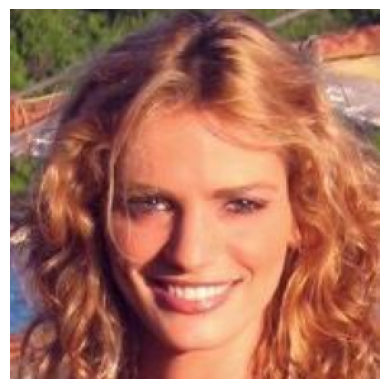

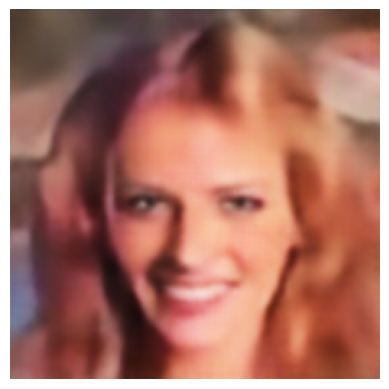

In [20]:
vae.eval()

imgs = next(iter(dataloader))
imgs = imgs.to(device)[:8]
with torch.no_grad():
    recon, _, _ = vae(imgs)

plot_image(imgs[0])
plot_image(recon[0])

Latent diffuser time!

In [21]:
T = 250 # No. of steps
diffusion_lr = 2e-4

betas = torch.linspace(1e-4, 0.02, T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)

def q_sample(z0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(z0)
    sqrt_alpha_bar = torch.sqrt(alphas_cumprod[t]).view(-1, 1)
    sqrt_one_minus = torch.sqrt(1.0 - alphas_cumprod[t]).view(-1, 1)
    return sqrt_alpha_bar * z0 + sqrt_one_minus * noise

In [22]:
class TimeEmbedding(nn.Module):
    def __init__(self, T, dim):
        super().__init__()
        self.emb = nn.Embedding(T, dim)

    def forward(self, t):
        return self.emb(t)

In [23]:
class LatentDenoiser(nn.Module):
    def __init__(self, latent_dim: int, time_dim: int, hidden_dim: int, T: int):
        super().__init__()
        self.time_emb = TimeEmbedding(T, time_dim)
        self.fc1 = nn.Linear(latent_dim + time_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, z_t, t):
        t_emb = self.time_emb(t)
        x = torch.cat([z_t, t_emb], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        eps_pred = self.fc3(x)
        return eps_pred

In [24]:
diffusion_model = LatentDenoiser(
    latent_dim=512,
    time_dim=32,
    hidden_dim=2014,
    T=T
).to(device)

diffusion_optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=diffusion_lr)

print("Diffusion parameters (M):", sum(p.numel() for p in diffusion_model.parameters())/1e6)
print(diffusion_model)

Diffusion parameters (M): 6.19552
LatentDenoiser(
  (time_emb): TimeEmbedding(
    (emb): Embedding(250, 32)
  )
  (fc1): Linear(in_features=544, out_features=2014, bias=True)
  (fc2): Linear(in_features=2014, out_features=2014, bias=True)
  (fc3): Linear(in_features=2014, out_features=512, bias=True)
)


In [25]:
dataloader_diffusion = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0)

print(f"Dataset size: {len(dataset)}")
print(f"No. of Batches: {len(dataloader_diffusion)}")
print(f"Sample shape: {dataset[0].shape}")

Dataset size: 50000
No. of Batches: 49
Sample shape: torch.Size([3, 256, 256])


In [47]:
diffusion_epochs = 50

diffusion_model.train()

for epoch in range(diffusion_epochs):
    total_loss = 0.0
    n_batches = 0

    pbar = tqdm(dataloader_diffusion, desc=f"Latent Diffuser Epoch {epoch+1}/{diffusion_epochs}")

    for x in pbar:
        x = x.to(device)
        batch_size = x.size(0)

        with torch.no_grad():
            mu, logvar = vae.encode(x)
            z0 = mu

        t = torch.randint(0, T, (batch_size,), device=device, dtype=torch.long)

        noise = torch.randn_like(z0)
        z_t = q_sample(z0, t, noise=noise)

        eps_pred = diffusion_model(z_t, t)

        loss = F.mse_loss(eps_pred, noise)

        pbar.set_postfix({"loss": loss.item()})

        diffusion_optimizer.zero_grad()
        loss.backward()
        diffusion_optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / n_batches
    print(f"Epoch {epoch + 1:02d} | MSE loss: {avg_loss:.6f}")

Latent Diffuser Epoch 1/50: 100%|██████████| 49/49 [07:41<00:00,  9.41s/it, loss=0.853]


Epoch 01 | MSE loss: 0.937609


Latent Diffuser Epoch 2/50: 100%|██████████| 49/49 [02:30<00:00,  3.06s/it, loss=0.711]


Epoch 02 | MSE loss: 0.775097


Latent Diffuser Epoch 3/50: 100%|██████████| 49/49 [02:31<00:00,  3.08s/it, loss=0.589]


Epoch 03 | MSE loss: 0.654323


Latent Diffuser Epoch 4/50: 100%|██████████| 49/49 [02:31<00:00,  3.10s/it, loss=0.57]


Epoch 04 | MSE loss: 0.575519


Latent Diffuser Epoch 5/50: 100%|██████████| 49/49 [02:32<00:00,  3.11s/it, loss=0.521]


Epoch 05 | MSE loss: 0.534160


Latent Diffuser Epoch 6/50: 100%|██████████| 49/49 [02:32<00:00,  3.11s/it, loss=0.492]


Epoch 06 | MSE loss: 0.512968


Latent Diffuser Epoch 7/50: 100%|██████████| 49/49 [02:31<00:00,  3.09s/it, loss=0.506]


Epoch 07 | MSE loss: 0.503054


Latent Diffuser Epoch 8/50: 100%|██████████| 49/49 [02:31<00:00,  3.09s/it, loss=0.518]


Epoch 08 | MSE loss: 0.498074


Latent Diffuser Epoch 9/50: 100%|██████████| 49/49 [02:31<00:00,  3.09s/it, loss=0.499]


Epoch 09 | MSE loss: 0.495525


Latent Diffuser Epoch 10/50: 100%|██████████| 49/49 [02:31<00:00,  3.10s/it, loss=0.488]


Epoch 10 | MSE loss: 0.490072


Latent Diffuser Epoch 11/50: 100%|██████████| 49/49 [02:30<00:00,  3.08s/it, loss=0.492]


Epoch 11 | MSE loss: 0.488291


Latent Diffuser Epoch 12/50: 100%|██████████| 49/49 [02:33<00:00,  3.13s/it, loss=0.499]


Epoch 12 | MSE loss: 0.487159


Latent Diffuser Epoch 13/50: 100%|██████████| 49/49 [02:32<00:00,  3.11s/it, loss=0.466]


Epoch 13 | MSE loss: 0.483691


Latent Diffuser Epoch 14/50: 100%|██████████| 49/49 [02:32<00:00,  3.12s/it, loss=0.476]


Epoch 14 | MSE loss: 0.481311


Latent Diffuser Epoch 15/50: 100%|██████████| 49/49 [02:33<00:00,  3.14s/it, loss=0.473]


Epoch 15 | MSE loss: 0.480287


Latent Diffuser Epoch 16/50: 100%|██████████| 49/49 [02:33<00:00,  3.12s/it, loss=0.488]


Epoch 16 | MSE loss: 0.475497


Latent Diffuser Epoch 17/50: 100%|██████████| 49/49 [02:35<00:00,  3.18s/it, loss=0.456]


Epoch 17 | MSE loss: 0.472754


Latent Diffuser Epoch 18/50: 100%|██████████| 49/49 [02:35<00:00,  3.17s/it, loss=0.466]


Epoch 18 | MSE loss: 0.470961


Latent Diffuser Epoch 19/50: 100%|██████████| 49/49 [02:33<00:00,  3.14s/it, loss=0.462]


Epoch 19 | MSE loss: 0.469742


Latent Diffuser Epoch 20/50: 100%|██████████| 49/49 [02:34<00:00,  3.15s/it, loss=0.464]


Epoch 20 | MSE loss: 0.468102


Latent Diffuser Epoch 21/50: 100%|██████████| 49/49 [02:32<00:00,  3.12s/it, loss=0.47]


Epoch 21 | MSE loss: 0.463250


Latent Diffuser Epoch 22/50: 100%|██████████| 49/49 [02:31<00:00,  3.09s/it, loss=0.462]


Epoch 22 | MSE loss: 0.463355


Latent Diffuser Epoch 23/50: 100%|██████████| 49/49 [02:31<00:00,  3.09s/it, loss=0.458]


Epoch 23 | MSE loss: 0.460140


Latent Diffuser Epoch 24/50: 100%|██████████| 49/49 [02:31<00:00,  3.10s/it, loss=0.436]


Epoch 24 | MSE loss: 0.456572


Latent Diffuser Epoch 25/50: 100%|██████████| 49/49 [02:35<00:00,  3.17s/it, loss=0.47]


Epoch 25 | MSE loss: 0.456455


Latent Diffuser Epoch 26/50: 100%|██████████| 49/49 [02:36<00:00,  3.19s/it, loss=0.461]


Epoch 26 | MSE loss: 0.456906


Latent Diffuser Epoch 27/50: 100%|██████████| 49/49 [02:33<00:00,  3.12s/it, loss=0.441]


Epoch 27 | MSE loss: 0.452810


Latent Diffuser Epoch 28/50: 100%|██████████| 49/49 [02:33<00:00,  3.14s/it, loss=0.451]


Epoch 28 | MSE loss: 0.453402


Latent Diffuser Epoch 29/50: 100%|██████████| 49/49 [02:33<00:00,  3.13s/it, loss=0.431]


Epoch 29 | MSE loss: 0.450413


Latent Diffuser Epoch 30/50: 100%|██████████| 49/49 [02:33<00:00,  3.13s/it, loss=0.46]


Epoch 30 | MSE loss: 0.447578


Latent Diffuser Epoch 31/50: 100%|██████████| 49/49 [02:32<00:00,  3.12s/it, loss=0.453]


Epoch 31 | MSE loss: 0.447489


Latent Diffuser Epoch 32/50: 100%|██████████| 49/49 [02:33<00:00,  3.13s/it, loss=0.455]


Epoch 32 | MSE loss: 0.447739


Latent Diffuser Epoch 33/50: 100%|██████████| 49/49 [02:32<00:00,  3.12s/it, loss=0.445]


Epoch 33 | MSE loss: 0.447124


Latent Diffuser Epoch 34/50: 100%|██████████| 49/49 [02:33<00:00,  3.14s/it, loss=0.446]


Epoch 34 | MSE loss: 0.446361


Latent Diffuser Epoch 35/50: 100%|██████████| 49/49 [02:33<00:00,  3.12s/it, loss=0.45]


Epoch 35 | MSE loss: 0.446498


Latent Diffuser Epoch 36/50: 100%|██████████| 49/49 [02:32<00:00,  3.11s/it, loss=0.445]


Epoch 36 | MSE loss: 0.445427


Latent Diffuser Epoch 37/50: 100%|██████████| 49/49 [02:33<00:00,  3.13s/it, loss=0.429]


Epoch 37 | MSE loss: 0.445133


Latent Diffuser Epoch 38/50: 100%|██████████| 49/49 [02:32<00:00,  3.12s/it, loss=0.442]


Epoch 38 | MSE loss: 0.443579


Latent Diffuser Epoch 39/50: 100%|██████████| 49/49 [02:32<00:00,  3.11s/it, loss=0.443]


Epoch 39 | MSE loss: 0.442052


Latent Diffuser Epoch 40/50: 100%|██████████| 49/49 [02:31<00:00,  3.09s/it, loss=0.451]


Epoch 40 | MSE loss: 0.440832


Latent Diffuser Epoch 41/50: 100%|██████████| 49/49 [02:31<00:00,  3.10s/it, loss=0.441]


Epoch 41 | MSE loss: 0.439233


Latent Diffuser Epoch 42/50: 100%|██████████| 49/49 [02:33<00:00,  3.13s/it, loss=0.445]


Epoch 42 | MSE loss: 0.437477


Latent Diffuser Epoch 43/50: 100%|██████████| 49/49 [02:31<00:00,  3.09s/it, loss=0.436]


Epoch 43 | MSE loss: 0.439091


Latent Diffuser Epoch 44/50: 100%|██████████| 49/49 [02:30<00:00,  3.08s/it, loss=0.437]


Epoch 44 | MSE loss: 0.435591


Latent Diffuser Epoch 45/50: 100%|██████████| 49/49 [02:32<00:00,  3.11s/it, loss=0.448]


Epoch 45 | MSE loss: 0.435885


Latent Diffuser Epoch 46/50: 100%|██████████| 49/49 [02:30<00:00,  3.07s/it, loss=0.427]


Epoch 46 | MSE loss: 0.437481


Latent Diffuser Epoch 47/50: 100%|██████████| 49/49 [02:31<00:00,  3.10s/it, loss=0.432]


Epoch 47 | MSE loss: 0.435974


Latent Diffuser Epoch 48/50: 100%|██████████| 49/49 [02:31<00:00,  3.10s/it, loss=0.418]


Epoch 48 | MSE loss: 0.434354


Latent Diffuser Epoch 49/50: 100%|██████████| 49/49 [02:32<00:00,  3.11s/it, loss=0.438]


Epoch 49 | MSE loss: 0.434245


Latent Diffuser Epoch 50/50: 100%|██████████| 49/49 [02:31<00:00,  3.09s/it, loss=0.448]

Epoch 50 | MSE loss: 0.435550


In [48]:
save_checkpoint(diffusion_model, diffusion_optimizer, epoch, loss, checkpoint_dir / 'latest_diffusion.pt')

In [45]:
epoch, loss = load_checkpoint(diffusion_model, diffusion_optimizer, checkpoint_dir / 'latest_diffusion.pt')
print(f"Epoch: {epoch}, Loss: {loss}")

Epoch: 49, Loss: 0.4478961229324341


In [46]:
@torch.no_grad()
def p_sample_step(z_t, t):
    b = z_t.size(0)
    t_tensor = torch.full((b,), t, device=device, dtype=torch.long)
    eps_pred = diffusion_model(z_t, t_tensor)

    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alphas_cumprod[t]
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - alpha_bar_t)

    z0_est = (z_t - sqrt_one_minus_alpha_bar_t * eps_pred) / torch.sqrt(alpha_bar_t)

    if t > 0:
        alpha_bar_prev = alphas_cumprod[t - 1]
        coef1 = torch.sqrt(alpha_bar_prev) * beta_t / (1.0 - alpha_bar_t)
        coef2 = torch.sqrt(alpha_t) * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t)
        mean = coef1 * z0_est + coef2 * z_t
        var = beta_t * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t)
        noise = torch.randn_like(z_t)
        z_prev = mean + torch.sqrt(var) * noise
    else:
        z_prev = z0_est
    return z_prev


@torch.no_grad()
def sample_latent_and_decode(n_samples=16):
    diffusion_model.eval()
    vae.eval()

    z_t = torch.randn(n_samples, 512, device=device)

    for t in reversed(range(T)):
        z_t = p_sample_step(z_t, t)

    x_hat_flat = vae.decode(z_t)
    x_hat = x_hat_flat.view(-1, 3, 256, 256)
    return x_hat.cpu()

In [50]:
samples = sample_latent_and_decode(n_samples=5)

In [51]:
samples.shape

torch.Size([5, 3, 256, 256])

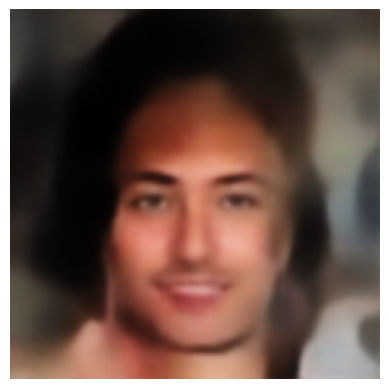

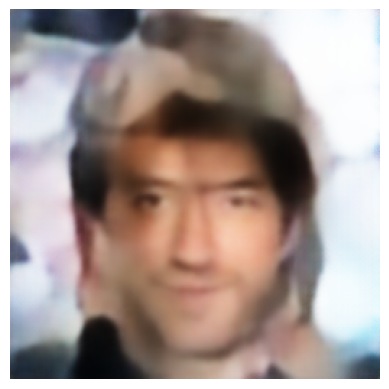

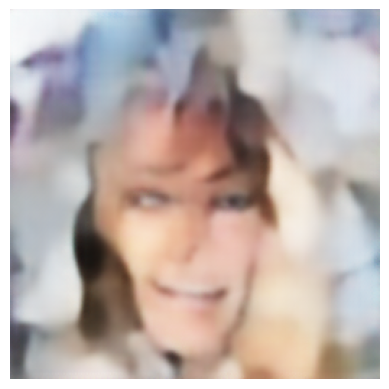

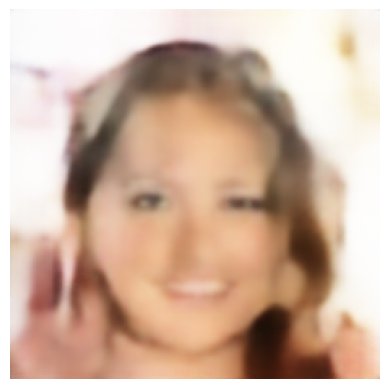

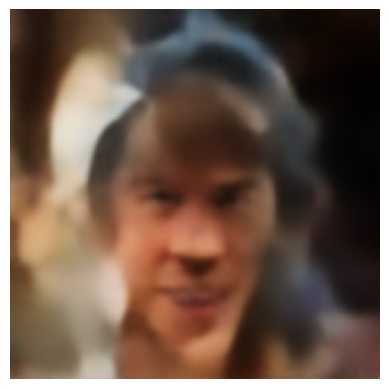

In [52]:
for image in samples:
  plot_image(image)